### ISS Camera Geolocation Example

Author: [timothy.j.lang@nasa.gov](mailto:timothy.j.lang@nasa.gov)

In addition to ISS Camera Geolocate dependencies, this notebook requires:
- [Cartopy](http://scitools.org.uk/cartopy/)
- [Python Imaging Library (PIL)](https://pypi.python.org/pypi/PIL) or [Pillow](https://pillow.readthedocs.io/en/4.2.x/)


This notebook will walk you through a simple ISS camera image geolocation example. The intent is to break down all the component steps, so that you understand what is going on in each. Then, you will understand how to combine many of these cells into a simple script or function for your own use. 

In [16]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import iss_camera_geolocate as icg
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
try:
    import Image
except ImportError:
    from PIL import Image
%matplotlib inline

In [17]:
jpfiles = glob.glob('./I*.jpg')
jpfiles

['./Img_01281.jpg']

1281


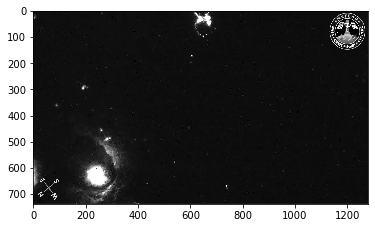

In [18]:
# Read in image
# This example is a frame from the Meteor camera on the ISS.
# This camera points near nadir and often detects lightning at night.
# This frame sees lightning in the vicinity of Del Rio, Texas.
# Convert to grayscale to speed up pcolormesh for geolocated image later
ii = 0
jpgfile = Image.open(jpfiles[ii]).convert("L")
data = np.asarray(jpgfile)
plt.imshow(jpgfile, cmap='Greys_r')
frame_num = int(os.path.basename(jpfiles[ii][-9:-4]))
print(frame_num)

(-0.5, 1279.5, 737.5, -0.5)

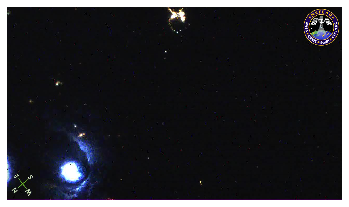

In [19]:
# See it in color!
jpgfile2 = Image.open(jpfiles[ii])
plt.imshow(jpgfile2, alpha=1)
plt.axis("off")

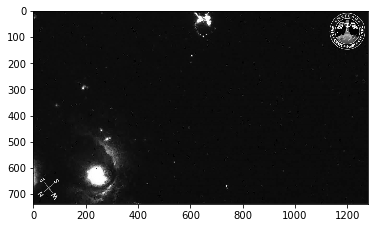

In [20]:
# The geolocation algorithm is slow for full-res pictures.
# Thinning them ahead of time can speed it up immensely.
thin = 1  # 1 for full res, higher for coarser image
data_crop = data[:, :]
crop_thin = data_crop[::thin, ::thin]
plt.imshow(crop_thin, cmap='gray')

In [21]:
# Using estimated info for Meteor 3 camera.
# Example image is from a compressed/cropped Meteor video,
# so effective focal plane dimensions have been estimated.
# More info here: http://www.perc.it-chiba.ac.jp/project/meteor/
# Insert your camera info here!
# You need to know focal length and focal plane dimensions (mm)
# as well as pixel reoslution of image.
camera_hres = np.shape(crop_thin)[1]
camera_vres = np.shape(crop_thin)[0]
camera_hdim = 8.7  # estimated horizontal size of camera focal plane in mm
camera_vdim = camera_hdim / (1280.0 / 720.0)
fl = 10.5  # focal length of camera in mm

# Get initial vector of photogrammetric info for image
vect = icg.get_camera_vector(fl, camera_hdim, camera_vdim, camera_hres, camera_vres)
vect.shape

(3, 944640)

In [22]:
# Two-line element (TLE) files for the ISS can be obtained
# from https://www.space-track.org/. Free login required.
# For this notebook, a text file covering first half of 2017
# has been provided.
tlef = glob.glob('./*.txt')
tlef

['./iss_tle_25544_20170101-20170630.txt']

In [23]:
# Estimate the time of the frame from Meteor video.
# This has been determined independently.
# For your own image, you must determine/estimate the datetime
mus = int(20649.526 * 1e6 + (frame_num - 1281) * (1 / 59.95) * 1e6)
dtstart = dt.datetime(2017, 5, 17, 0, 0, 0, 0) + dt.timedelta(microseconds=mus)
tle, datet = icg.get_tles_and_datetimes(tlef[0])
dtstart

datetime.datetime(2017, 5, 17, 5, 44, 9, 526000)

In [24]:
# Find the closest TLE to the image datetime then propagate the ISS
# to the correction position.
dt1 = dtstart + dt.timedelta(seconds=0)
dt_close, line1, line2 = icg.get_closest_tle(dt1, tle, datet, verbose=False)
# Leveraging SGP4 orbit calculation module in next two lines
satellite = icg.twoline2rv(line1, line2, icg.wgs84)
position, velocity = satellite.propagate(
    dt1.year, dt1.month, dt1.day,
    dt1.hour, dt1.minute, dt1.second + 1e-6 * dt1.microsecond)
print(dt1, position)

2017-05-17 05:44:09.526000 (-4511.426351704235, -3758.4779944700913, 3392.532587993558)


In [25]:
# The geolocation algorithm works best for small roll/pitch angles (< 10 deg).
# These must be estimated from camera/spacecraft info, or via trial
# and error against a geolocated database (e.g., city lights, coastlines)
roll = 5.5  # degrees  5.5
pitch = 1.1  # degrees  1.1
yaw = 185.5  # degrees  185.5

In [26]:
# This cell could take a while if image has not been coarsened.
# Rotation and transformation matrices will be computed and then
# used to geolocate all image pixels.
P = np.array(position)
V = np.array(velocity)
A = icg.get_A_matrix(roll, pitch, yaw)
f = icg.get_f()
M = icg.get_M(P, V, f)
lats, lons = icg.loop_over_each_pixel_and_geolocate_it(vect, M, A, P)

i = 0 [-4126.86964556 -3639.53791186  3214.60839185] 30.461811350717092 -138.5905263755171
i = 500000 [-4299.05077361 -3509.77928351  3132.74793223] 29.60880090955061 -140.7715261198586
64.5509397983551 seconds to process


In [27]:
# Correct longitudes for Greenwich Hour Angle
# Then alias longitudes to +/- 360 deg and reshape arrays back to 2D
GHA = icg.get_GHA(dt1)
plons = lons - GHA
plons[plons <= -360] += 360.0
plons[plons >= 360] -= 360.0

# plat and plon are the ultimate result:
# 2D arrays of lat/lon coordinates w/ same
# size as the image - suitable for input to pyplot.pcolormesh, etc.
plon = plons.reshape(np.shape(crop_thin))
plat = lats.reshape(np.shape(crop_thin))

### Check out geolocated image

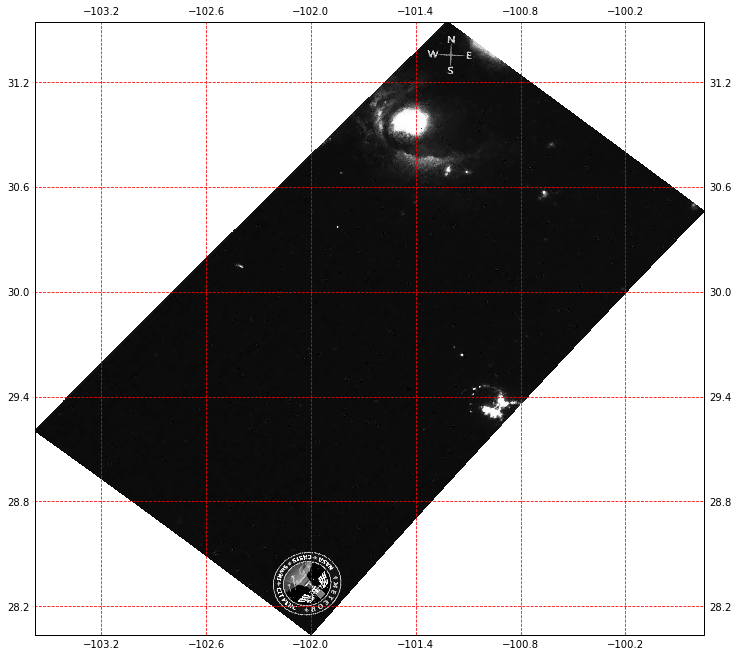

In [28]:
fig = plt.figure(figsize=(12, 12))
ext = [np.min(plon), np.max(plon), np.min(plat), np.max(plat)]

projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.set_extent(ext)

ax.pcolormesh(plon, plat, crop_thin, cmap='gray',
              vmin=0, vmax=255, transform=projection)
ax.coastlines(resolution='10m')

# Create a feature for states/countries at 1:10m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
ax.add_feature(states_provinces)
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')
ax.add_feature(countries)

ax.gridlines(draw_labels=True, color='r', linestyle='--')

We can also compare the image against the VIIRS city lights database

Frame 2017-05-17 05:44:09.526000


Text(0.5, 1.05, 'Meteor + VIIRS 20170517_054409')

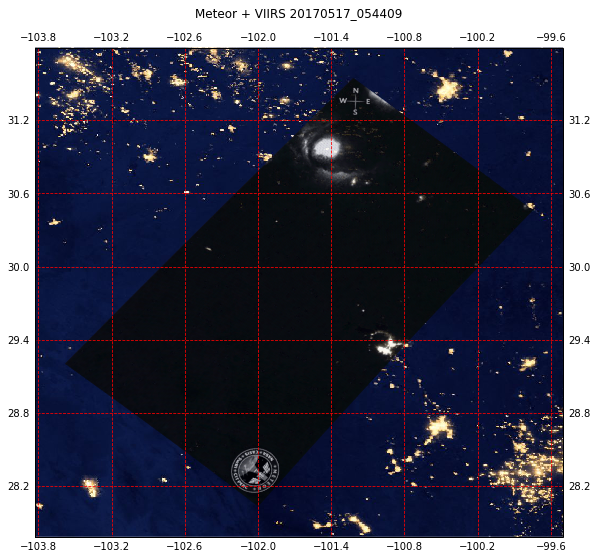

In [29]:
fig = plt.figure(figsize=(10, 9))
ext = [np.min(plon) - 0.25, np.max(plon) + 0.25,
       np.min(plat) - 0.25, np.max(plat) + 0.25]
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.set_extent(ext, crs=projection)

base_url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
layer_name = 'VIIRS_CityLights_2012'

if thin == 1:
    alpha = 0.10
else:
    alpha = 0.35

ax.pcolormesh(plon, plat, crop_thin, cmap='gray', vmin=0, vmax=255,
              transform=projection, alpha=alpha)

# Add WMTS imaging
ax.add_wmts(base_url, layer_name=layer_name)

ax.coastlines(resolution='10m')
ax.add_feature(states_provinces)
ax.add_feature(countries)

print('Frame', dt1)

ax.gridlines(draw_labels=True, color='r', linestyle='--')
ax.set_title('Meteor + VIIRS ' + dt1.strftime('%Y%m%d_%H%M%S'), y=1.05)